/var/folders/x4/f0yhttf57678gq_cpd4czrfm0000gn/T/ipykernel_30285/1235180081.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Monthly Expenses'].fillna(data['Monthly Expenses'].median(), inplace=True)
/var/folders/x4/f0yhttf57678gq_cpd4czrfm0000gn/T/ipykernel_30285/1235180081.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object o

Financial analysis completed. Report saved as 'Analysis_report.docx'.


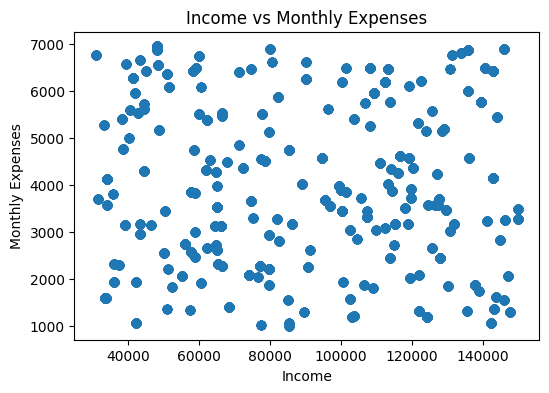

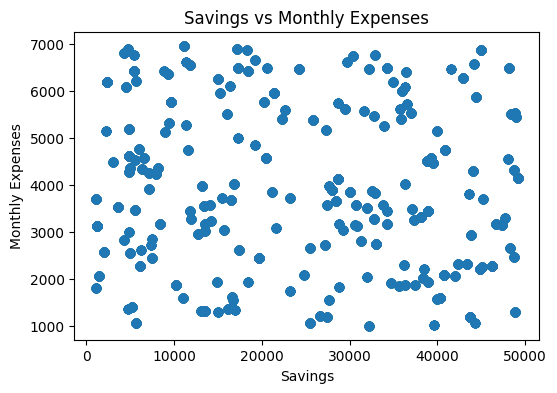

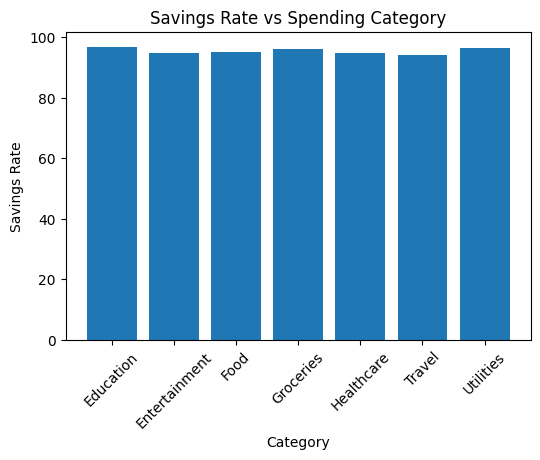

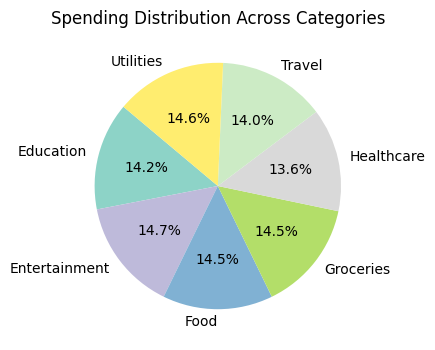

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from docx import Document

# Load your dataset
data = pd.read_excel('finance.xlsx')

# --- 1. Missing Values Check ---
# Fill missing values with median for numerical columns
data['Monthly Expenses'].fillna(data['Monthly Expenses'].median(), inplace=True)
data['Income'].fillna(data['Income'].median(), inplace=True)

# Ensure 'Transaction Date' is datetime
data['Transaction Date'] = pd.to_datetime(data['Transaction Date'], errors='coerce')

# --- 2. Family-Level Data Aggregation ---
family_data = data.groupby('Family ID').agg({
    'Monthly Expenses': 'sum',
    'Income': 'sum',
    'Savings': 'sum',
    'Loan Payments': 'sum',
    'Credit Card Spending': 'sum'
}).reset_index()

# Calculate family-level ratios
family_data['Income vs Expenses'] = family_data['Income'] / family_data['Monthly Expenses']
family_data['Savings Rate'] = family_data['Savings'] / family_data['Income']

# --- 3. Member-Level Data Aggregation ---
member_data = data.groupby(['Member ID', 'Category']).agg({
    'Amount': 'sum',
    'Income': 'first',  # Assuming constant income for each member
    'Savings': 'first'
}).reset_index()

# Calculate member-level spending and savings ratios
member_data['Spending to Income'] = member_data['Amount'] / member_data['Income']
member_data['Savings to Spending Ratio'] = member_data['Savings'] / member_data['Amount']

# --- 4. Analysis and Visualizations ---
# Initialize Word Document
doc = Document()
doc.add_heading('Financial Data Analysis', 0)

# Missing values summary
doc.add_heading('1. Missing Values Check', level=1)
doc.add_paragraph("This analysis checks for missing values and fills them with appropriate measures.")
missing_values = data.isnull().sum()
doc.add_paragraph(f"Missing values before filling:\n{missing_values.to_string()}")

# Income vs Monthly Expenses Scatter Plot
doc.add_heading('2. Income vs Monthly Expenses', level=1)
doc.add_paragraph("This scatter plot visualizes the relationship between income and monthly expenses.")
plt.figure(figsize=(6, 4))
plt.scatter(data['Income'], data['Monthly Expenses'], alpha=0.6)
plt.title('Income vs Monthly Expenses')
plt.xlabel('Income')
plt.ylabel('Monthly Expenses')
plt.savefig('income_vs_expenses.png')
doc.add_picture('income_vs_expenses.png')

# Correlation between Income and Monthly Expenses
income_expenses_corr = data[['Income', 'Monthly Expenses']].corr().iloc[0, 1]
doc.add_paragraph(f"Correlation between Income and Monthly Expenses: {income_expenses_corr:.2f}")

# Savings vs Monthly Expenses Scatter Plot
doc.add_heading('3. Savings vs Monthly Expenses', level=1)
doc.add_paragraph("This scatter plot visualizes the relationship between savings and monthly expenses.")
plt.figure(figsize=(6, 4))
plt.scatter(data['Savings'], data['Monthly Expenses'], alpha=0.6)
plt.title('Savings vs Monthly Expenses')
plt.xlabel('Savings')
plt.ylabel('Monthly Expenses')
plt.savefig('savings_vs_expenses.png')
doc.add_picture('savings_vs_expenses.png')

# Correlation between Savings and Monthly Expenses
savings_expenses_corr = data[['Savings', 'Monthly Expenses']].corr().iloc[0, 1]
doc.add_paragraph(f"Correlation between Savings and Monthly Expenses: {savings_expenses_corr:.2f}")

# Savings Rate vs Spending Category
category_spending = data.groupby('Category').agg({
    'Amount': 'sum',
    'Savings': 'sum'
}).reset_index()
category_spending['Savings Rate'] = category_spending['Savings'] / category_spending['Amount']

doc.add_heading('4. Savings Rate vs Spending Category', level=1)
doc.add_paragraph("A bar chart visualizing savings rates across spending categories.")
plt.figure(figsize=(6, 4))
plt.bar(category_spending['Category'], category_spending['Savings Rate'])
plt.title('Savings Rate vs Spending Category')
plt.xlabel('Category')
plt.ylabel('Savings Rate')
plt.xticks(rotation=45)
plt.savefig('savings_rate_vs_category.png')
doc.add_picture('savings_rate_vs_category.png')

# Spending Distribution Across Categories
doc.add_heading('5. Spending Distribution Across Categories', level=1)
doc.add_paragraph("This pie chart shows the proportion of spending across various categories.")
category_spending_pie = data.groupby('Category')['Amount'].sum()
plt.figure(figsize=(6, 4))
category_spending_pie.plot(kind='pie', autopct='%1.1f%%', startangle=140, cmap='Set3')
plt.title('Spending Distribution Across Categories')
plt.ylabel('')
plt.savefig('spending_distribution_across_categories.png')
doc.add_picture('spending_distribution_across_categories.png')

# Save the document
doc.save('Analysis_report.docx')

print("Financial analysis completed. Report saved as 'Analysis_report.docx'.")

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, r2_score

# Load the dataset
data = pd.read_excel("/Users/vyakaranamsowmya/Desktop/docs/CHINNA ASSIGNMNET/cleaned_and_preprocessed_finance.xlsx")

# Create Financial Score based on provided criteria
def calculate_financial_score(row):
    savings_to_income = row['Savings'] / row['Income'] if row['Income'] > 0 else 0
    expenses_to_income = row['Monthly Expenses'] / row['Income'] if row['Income'] > 0 else 1
    loan_to_income = row['Loan Payments'] / row['Income'] if row['Income'] > 0 else 1
    credit_card_spending = row['Credit Card Spending'] / data['Credit Card Spending'].max()
    financial_goals_met = row['Financial Goals Met (%)'] / 100

    travel_spending = 0
    entertainment_spending = 0
    if row['Category'] == 'Travel':
        travel_spending = row['Amount'] / data[data['Category'] == 'Travel']['Amount'].max() if 'Travel' in data['Category'].values else 0
    elif row['Category'] == 'Entertainment':
        entertainment_spending = row['Amount'] / data[data['Category'] == 'Entertainment']['Amount'].max() if 'Entertainment' in data['Category'].values else 0

    score = (
        0.25 * savings_to_income -       
        0.20 * expenses_to_income -      
        0.20 * loan_to_income -          
        0.15 * credit_card_spending -    
        0.10 * financial_goals_met +     
        0.05 * travel_spending -         
        0.05 * entertainment_spending    
    )
    return max(0, min(100, score * 100))

data['Financial Score'] = data.apply(calculate_financial_score, axis=1)

# Normalize only non-monetary features
scaler = MinMaxScaler()
numerical_features = ['Income', 'Loan Payments', 'Credit Card Spending', 'Financial Goals Met (%)']
data[numerical_features] = scaler.fit_transform(data[numerical_features])

# Define Input features (X) and target variables
X = data[numerical_features]
y_score = data['Financial Score']
y_expenses = data['Monthly Expenses']
y_savings = data['Savings']

# Split data for all models
X_train, X_test, y_train_score, y_test_score = train_test_split(X, y_score, test_size=0.2, random_state=42)
_, _, y_train_exp, y_test_exp = train_test_split(X, y_expenses, test_size=0.2, random_state=42)
_, _, y_train_sav, y_test_sav = train_test_split(X, y_savings, test_size=0.2, random_state=42)

# Build Neural Network for Financial Score
def build_model():
    model = Sequential()
    model.add(Dense(units=64, activation='relu', input_dim=X_train.shape[1]))
    model.add(Dense(units=32, activation='relu'))
    model.add(Dense(units=1, activation='linear'))
    model.compile(optimizer=Adam(), loss='mean_squared_error')
    return model

# Financial Score Model
nn_model = build_model()
nn_model.fit(X_train, y_train_score, epochs=100, batch_size=32, validation_data=(X_test, y_test_score), callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=0)

# Expenses Model
expenses_model = build_model()
expenses_model.fit(X_train, y_train_exp, epochs=100, batch_size=32, validation_data=(X_test, y_test_exp), callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=0)

# Savings Model
savings_model = build_model()
savings_model.fit(X_train, y_train_sav, epochs=100, batch_size=32, validation_data=(X_test, y_test_sav), callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=0)

# Add Predictions to Dataset
data['Next Month\'s Financial Score'] = nn_model.predict(X, verbose=0)
data['Next Month\'s Expenses'] = expenses_model.predict(X, verbose=0)
data['Next Month\'s Savings'] = savings_model.predict(X, verbose=0)

# Save updated dataset
data.to_excel("Finance_Predictions.xlsx", index=False)

# Accuracy Calculation and Output
y_pred_score = nn_model.predict(X_test, verbose=0)
y_pred_expenses = expenses_model.predict(X_test, verbose=0)
y_pred_savings = savings_model.predict(X_test, verbose=0)

score_accuracy = r2_score(y_test_score, y_pred_score) * 100
expenses_accuracy = r2_score(y_test_exp, y_pred_expenses) * 100
savings_accuracy = r2_score(y_test_sav, y_pred_savings) * 100

print(f"Financial Score Accuracy: {score_accuracy:.2f}%")
print(f"Expenses Prediction Accuracy: {expenses_accuracy:.2f}%")
print(f"Savings Prediction Accuracy: {savings_accuracy:.2f}%")

/Users/vyakaranamsowmya/Desktop/docs/CHINNA ASSIGNMNET/elizibit/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/vyakaranamsowmya/Desktop/docs/CHINNA ASSIGNMNET/elizibit/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/vyakaranamsowmya/Desktop/docs/CHINNA ASSIGNMNET/elizibit/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models,

Financial Score Accuracy: 96.01%
Expenses Prediction Accuracy: 0.51%
Savings Prediction Accuracy: 4.72%


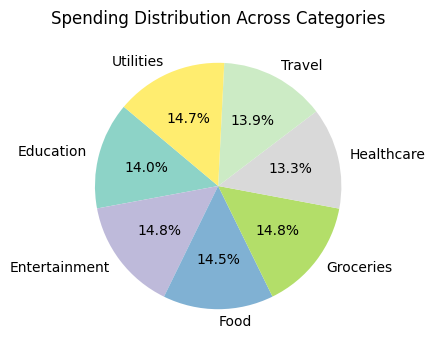

/var/folders/x4/f0yhttf57678gq_cpd4czrfm0000gn/T/ipykernel_30285/3826538271.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=family_scores, x='Family ID', y='Financial Score', palette='viridis')


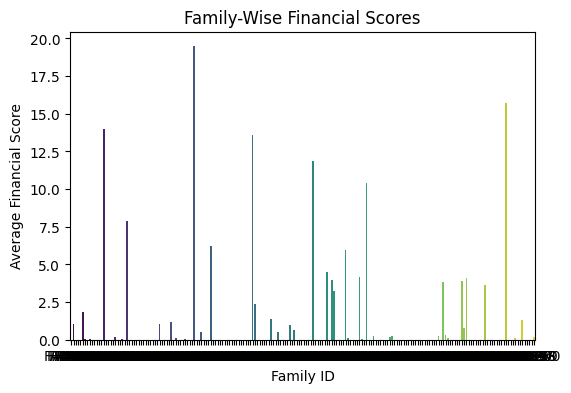

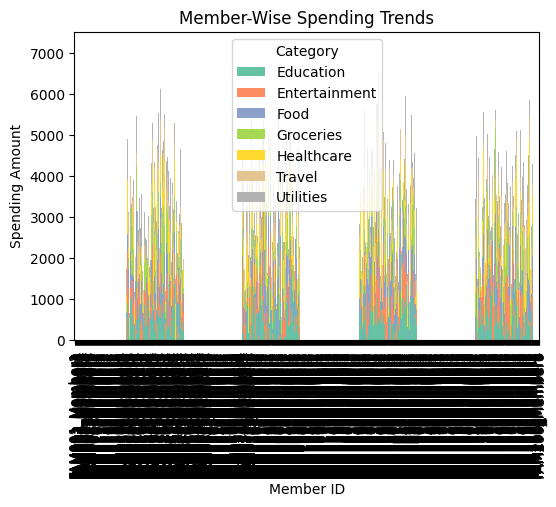

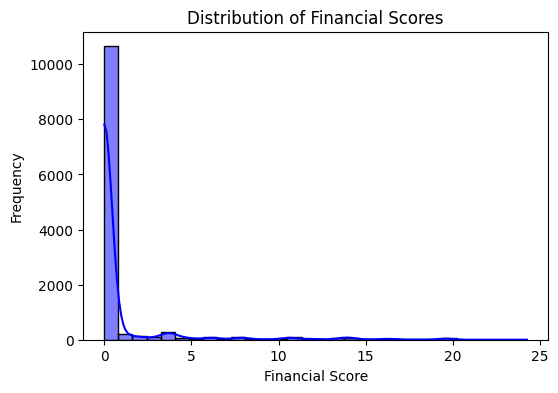

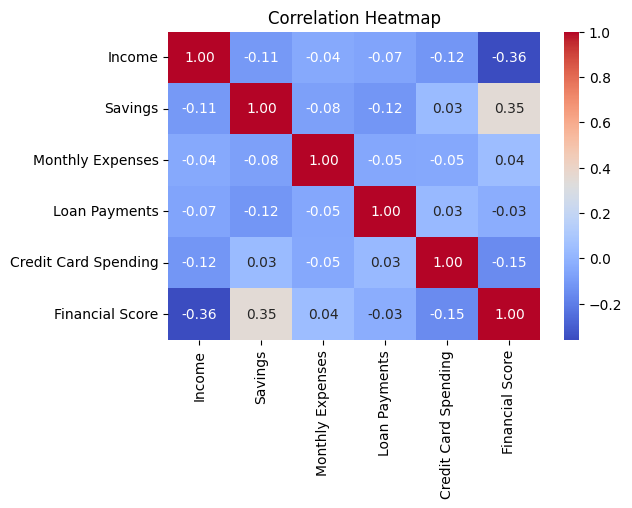

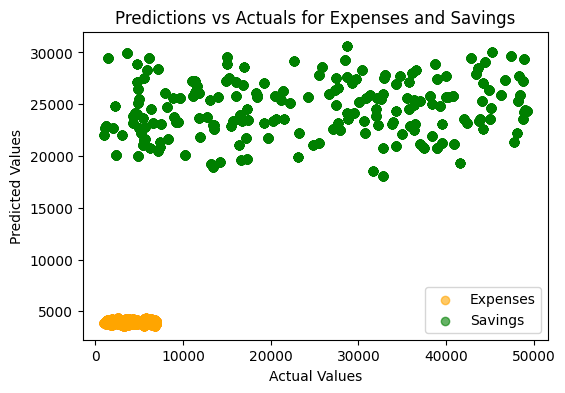

=== Terminal Insights ===
1. Spending Distribution Across Categories:
Category
Education        432984.97
Entertainment    457687.08
Food             447809.85
Groceries        456329.76
Healthcare       409913.56
Travel           427905.36
Utilities        452843.12
Name: Amount, dtype: float64

2. Family-Wise Financial Scores:
    Family ID  Financial Score
0      FAM001         0.000000
1      FAM002         1.033646
2      FAM003         0.000000
3      FAM004         0.000000
4      FAM005         0.000000
..        ...              ...
195    FAM196         0.000000
196    FAM197         0.000000
197    FAM198         0.000000
198    FAM199         0.000000
199    FAM200         0.169353

[200 rows x 2 columns]

3. Correlation Heatmap:
                        Income   Savings  Monthly Expenses  Loan Payments  \
Income                1.000000 -0.108374         -0.042416      -0.066885   
Savings              -0.108374  1.000000         -0.079224      -0.119820   
Monthly Expenses 

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from docx import Document

# Load the dataset
data = pd.read_excel("Finance_Predictions.xlsx")  # Assuming predictions are already added.

# Initialize Word Document
doc = Document()
doc.add_heading('Financial Data Analysis - Insights', 0)

# --- Spending Distribution Across Categories ---
doc.add_heading('1. Spending Distribution Across Categories', level=1)
category_spending = data.groupby('Category')['Amount'].sum()
plt.figure(figsize=(6, 4))
category_spending.plot(kind='pie', autopct='%1.1f%%', startangle=140, cmap='Set3')
plt.title('Spending Distribution Across Categories')
plt.ylabel('')
plt.savefig('spending_distribution.png')
doc.add_paragraph("This pie chart shows the proportion of spending across various categories, highlighting the dominant areas of expenditure.")
doc.add_picture('spending_distribution.png')
plt.show()

# --- Family-Wise Financial Scores ---
doc.add_heading('2. Family-Wise Financial Scores', level=1)
family_scores = data.groupby('Family ID')['Financial Score'].mean().reset_index()
plt.figure(figsize=(6,4))
sns.barplot(data=family_scores, x='Family ID', y='Financial Score', palette='viridis')
plt.title('Family-Wise Financial Scores')
plt.xlabel('Family ID')
plt.ylabel('Average Financial Score')
plt.savefig('family_scores.png')
doc.add_paragraph("This bar chart shows the average financial score for each family, indicating financial health differences across families.")
doc.add_picture('family_scores.png')
plt.show()

# --- Member-Wise Spending Trends ---
doc.add_heading('3. Member-Wise Spending Trends', level=1)
member_spending = data.groupby(['Member ID', 'Category'])['Amount'].sum().unstack()
member_spending.plot(kind='bar', stacked=True, figsize=(6,4), colormap='Set2')
plt.title('Member-Wise Spending Trends')
plt.xlabel('Member ID')
plt.ylabel('Spending Amount')
plt.legend(title='Category')
plt.savefig('member_spending_trends.png')
doc.add_paragraph("This stacked bar chart visualizes member-wise spending trends across different categories, providing insights into individual spending behaviors.")
doc.add_picture('member_spending_trends.png')
plt.show()

# --- Financial Score Distribution ---
doc.add_heading('4. Financial Score Distribution', level=1)
plt.figure(figsize=(6,4))
sns.histplot(data['Financial Score'], bins=30, kde=True, color='blue')
plt.title('Distribution of Financial Scores')
plt.xlabel('Financial Score')
plt.ylabel('Frequency')
plt.savefig('financial_score_distribution.png')
doc.add_paragraph("This histogram shows the distribution of financial scores, helping identify the range and common score brackets.")
doc.add_picture('financial_score_distribution.png')
plt.show()

# --- Correlation Heatmap ---
doc.add_heading('5. Correlation Heatmap of Financial Features', level=1)
correlation_matrix = data[['Income', 'Savings', 'Monthly Expenses', 'Loan Payments', 'Credit Card Spending', 'Financial Score']].corr()
plt.figure(figsize=(6,4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.savefig('correlation_heatmap.png')
doc.add_paragraph("This heatmap shows correlations among key financial variables, revealing how different factors influence financial scores and behaviors.")
doc.add_picture('correlation_heatmap.png')
plt.show()

# --- Predictions vs Actuals (Matplotlib Approach) ---
doc.add_heading('6. Predictions vs. Actuals for Next Month', level=1)

# Scatter plot for predicted vs actual expenses
plt.figure(figsize=(6,4))
plt.scatter(data['Monthly Expenses'], data['Next Month\'s Expenses'], color='orange', alpha=0.6, label="Expenses")
plt.scatter(data['Savings'], data['Next Month\'s Savings'], color='green', alpha=0.6, label="Savings")
plt.title('Predictions vs Actuals for Expenses and Savings')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.savefig('predictions_vs_actuals.png')
doc.add_paragraph("This scatter plot compares actual and predicted values for next month's expenses and savings. "
                  "It evaluates the accuracy of predictions made by the financial model, providing insights into model performance.")
doc.add_picture('predictions_vs_actuals.png')
plt.show()

# Save Word Document
doc.save("Visualisation_Insights.docx")

# Terminal Outputs
print("=== Terminal Insights ===")
print("1. Spending Distribution Across Categories:")
print(category_spending)

print("\n2. Family-Wise Financial Scores:")
print(family_scores)

print("\n3. Correlation Heatmap:")
print(correlation_matrix)

print("\nFinancial Analysis Completed. Insights saved in 'Visualisation_Insights.docx'.")